In [14]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Number of samples
n_samples = 5000

# Features
lam_temp = np.random.normal(90, 10, n_samples)        # mean 90°C, 70-110
lam_pressure = np.random.normal(550, 50, n_samples)   # mean 550 N, 400-700 N
long_side_sealer_temp  = np.random.normal(180, 5, n_samples) # mean 180, 150-200
short_side_sealer_temp = np.random.normal(180, 5, n_samples) # mean 180, 150-200
long_side_sealer_pressure  = np.random.normal(500, 30, n_samples) # mean 500, 400-600 N
short_side_sealer_pressure = np.random.normal(500, 30, n_samples) # mean 500, 400-600 N
heater_temp = np.random.normal(80, 5, n_samples) # mean 80, 60-100


# Defect probability model
prob_defect = np.zeros(n_samples)

# Lamination temperature (too low → poor adhesion, wrinkles; too high → thermal damage)
prob_defect += (lam_temp < 85) * 0.5
prob_defect += (lam_temp > 100) * 0.3

# Lamination pressure (too low → weak bonding; too high → material damage)
prob_defect += (lam_pressure < 480) * 0.4
prob_defect += (lam_pressure > 620) * 0.2

# Sealing temperatures (too low → poor sealing; too high → burn-through)
prob_defect += ((short_side_sealer_temp < 170) | (long_side_sealer_temp < 170)) * 0.4
prob_defect += ((short_side_sealer_temp > 190) | (long_side_sealer_temp > 190)) * 0.2

# Sealing pressures (too low → incomplete seal; too high → misalignment / deformation)
prob_defect += ((short_side_sealer_pressure < 470) | (long_side_sealer_pressure < 470)) * 0.35
prob_defect += ((short_side_sealer_pressure > 550) | (long_side_sealer_pressure > 550)) * 0.15

# Heater temperature (too low → non-uniform heating; too high → film shrinkage)
prob_defect += (heater_temp < 70) * 0.25
prob_defect += (heater_temp > 90) * 0.10

# Add random noise
prob_defect += np.random.normal(0, 0.02, n_samples)
prob_defect = np.clip(prob_defect, 0, 1)

# Generate binary defect label
y = np.random.binomial(1, prob_defect)

# Build dataframe
X = pd.DataFrame({
     "lam_temp": lam_temp,
        "lam_pressure": lam_pressure,
        "long_side_sealer_temp": long_side_sealer_temp,
        "short_side_sealer_temp": short_side_sealer_temp,
        "long_side_sealer_pressure": long_side_sealer_pressure,
        "short_side_sealer_pressure": short_side_sealer_pressure,
        "heater_temp": heater_temp
})

print(X.head())

     lam_temp  lam_pressure  long_side_sealer_temp  short_side_sealer_temp  \
0   94.967142    528.812016             176.607526              179.282884   
1   88.617357    527.329295             178.472503              179.836720   
2   96.476885    460.217841             177.013095              180.321474   
3  105.230299    533.495490             180.552090              184.734307   
4   87.658466    586.641454             185.985893              176.263913   

   long_side_sealer_pressure  short_side_sealer_pressure  heater_temp  
0                 510.448587                  505.126206    70.097140  
1                 508.499708                  500.367663    74.725072  
2                 471.904405                  487.065348    77.064858  
3                 517.387527                  499.924200    80.748345  
4                 455.297520                  514.725249    85.120812  


In [10]:
# --------------------------
# Train the classifier
# --------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance dataset with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train Random Forest
model = RandomForestClassifier(n_estimators=300, max_depth=8, class_weight="balanced", random_state=42)
model.fit(X_train_res, y_train_res)

#Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.732
              precision    recall  f1-score   support

           0       0.82      0.71      0.77       613
           1       0.63      0.76      0.69       387

    accuracy                           0.73      1000
   macro avg       0.73      0.74      0.73      1000
weighted avg       0.75      0.73      0.74      1000



/tmp/ipython-input-1441442400.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_df, palette="viridis", orient="h")


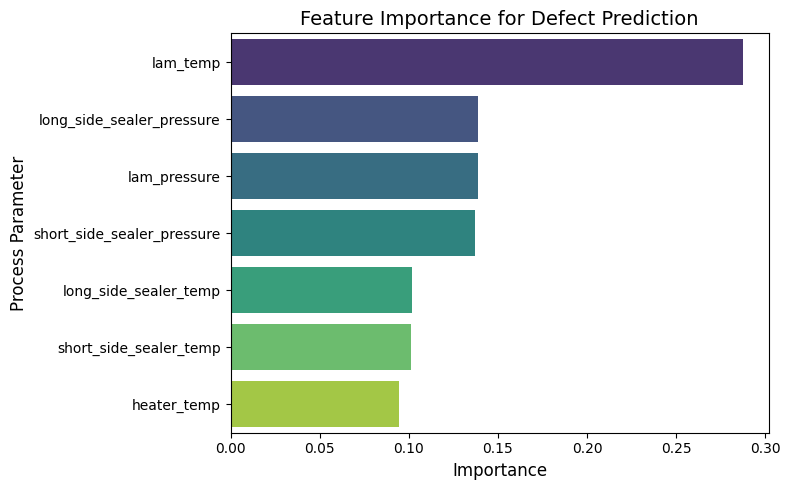

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --------------------------
# Feature Importance Plot
# --------------------------
importances = model.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi_df = fi_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df, palette="viridis", orient="h")
plt.title("Feature Importance for Defect Prediction", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Process Parameter", fontsize=12)
plt.tight_layout()
plt.show()